This notebook generates simulation data and plots of the paper:

[An Information Theory of Compute-Optimal Size Scaling, Emergence, and Plateaus in Language Models](https://openreview.net/forum?id=wZWcslCVFY)

ArXiv version: https://arxiv.org/abs/2410.01243

# Functions

## Core functions

In [ ]:
import numpy as np
from matplotlib import cm
import matplotlib.pyplot as plt
from scipy.stats import *
import scipy as scp

X_MIN = 0.1
NUM_PTS = 40

'''
Fixed point characterization of threshold
'''
## binomial only
def lambda_func_binomial(x, p, n):
  return (p*x+(1-p))**(n-1)

def lambda_prime_func_binomial(x, p, n):
  return (n-1)*p*((p*x+(1-p))**(n-2))

def L_func_binomial(x, p, n):
  denom = (1-(1-p)**n)
  numer = (p*x+(1-p))**(n)-(1-p)**n #(*)
  return numer/denom

def L_prime_func_binomial(x, p, n):
  denom = (1-(1-p)**n)
  numer = n*p*(p*x+(1-p))**(n-1) # second term in (*) is a constant => vanishes after taking derivative
  return numer/denom

def rho_func_binomial(x, p, n):
  return (p*x+(1-p))**(n-1)

def rho_prime_func_binomial(x, p, n):
  return (n-1)*p*((p*x+(1-p))**(n-2))

def func_fx_pt(x, eps, nv, nc, pv, pc, neg=False):
    if neg:
      return -(x-eps*lambda_func_binomial(1-rho_func_binomial(1-x, pc, nc), pv, nv))
    else:
      return x-eps*lambda_func_binomial(1-rho_func_binomial(1-x, pc, nc), pv, nv)


'''
Computes \epsilon^{BP} for regular LDPC codes with right (check node) degree = r and left (variable node) degree = l
'''
def get_epsilon_BP(nv, nc, pv, pc):
  eps_low = np.float128(1e-16)
  eps_high = np.float128(1-eps_low)
  eps_tolerance = np.float128(1e-16)
  num_iters = 100
  iter = 0
  eps_BP = eps_high
  while iter < num_iters and np.abs(eps_low-eps_high)>eps_tolerance:

    eps_tmp = (eps_low+eps_high)/2
    if is_solution_in_0_1(eps_tmp, nv, nc, pv, pc) == 0:
      eps_low = eps_tmp
    else:
      eps_high = eps_tmp
    iter += 1

  if iter>0.9*num_iters:
    print("max iters reached")

  eps_BP = eps_tmp
  while is_solution_in_0_1(eps_BP, nv, nc, pv, pc) == 0 and eps_BP+eps_tolerance<1.0:
      eps_BP = eps_BP+eps_tolerance

  return eps_BP


'''
Optimize: grid search followed by scipy.optimize
'''
def my_minimizer(my_fun, args, x_low, x_high, num_pts=40):
  tol_val = 1e-18
  x_vec_tmp = np.linspace(x_low, x_high, num_pts)
  f_vec_tmp = np.zeros(x_vec_tmp.shape)
  for ind_x, x in enumerate(x_vec_tmp):
      f_min_tmp = my_fun(x, *args)
      f_vec_tmp[ind_x] = f_min_tmp
  x_init = x_vec_tmp[np.argmin(f_vec_tmp)]

  x_lb = x_vec_tmp[max(np.argmin(f_vec_tmp)-1, 0)]
  x_ub =x_vec_tmp[min(np.argmin(f_vec_tmp)+1, len(f_vec_tmp)-1)]

  x_init = np.float128(x_init)
  minimizer_kwargs = {'method':'Bounded', 'bounds':(x_lb, x_ub), 'args':tuple(args), 'tol':tol_val}
  x_opt = scp.optimize.minimize_scalar(my_fun, **minimizer_kwargs).x


  return x_opt

'''
Checking if x - \lambda(1-\rho(1-x)) intersects x-axis or not for any x \in (0, 1] (Note the exclusion of 0)
If it intersects, then the root corresponds to eps_tmp > \epsilon^{BP}
'''
def is_solution_in_0_1(eps_tmp, nv, nc, pv, pc):
  x_low = X_MIN
  x_high = 1

  # min
  args = [eps_tmp, nv, nc, pv, pc, False]
  min_x = my_minimizer(func_fx_pt, args, x_low, x_high, num_pts=NUM_PTS)
  # max
  args = [eps_tmp, nv, nc, pv, pc, True]
  max_x = my_minimizer(func_fx_pt, args, x_low, x_high, num_pts=NUM_PTS)

  if np.sign(func_fx_pt(min_x, eps_tmp, nv, nc, pv, pc)) == np.sign(func_fx_pt(max_x, eps_tmp, nv, nc, pv, pc)):
    return 0
  else:
    return 1


def get_x_BP(eps_BP, nv, nc, pv, pc):
  x_low = X_MIN
  x_high = 1
  eps_BP = eps_BP

  if is_solution_in_0_1(eps_BP, nv, nc, pv, pc) == 0:
    x_BP = X_MIN
  else:
    args = [eps_BP, nv, nc, pv, pc, False]
    x_BP = my_minimizer(func_fx_pt, args, x_low, x_high, num_pts=NUM_PTS)

  return x_BP

'''
compute alpha for a given degree distribution
'''
def get_alpha(nv, nc, pv, pc, x_BP, eps_BP):
  if x_BP == X_MIN:
    alpha_val = 1e-5 # some small value so that P_B -> 0
  else:
    x_BP_bar = 1-x_BP
    y_BP = 1-rho_func_binomial(x_BP_bar, pc, nc)
    term1_numer1_2 = rho_func_binomial(x_BP_bar, pc, nc)**2-rho_func_binomial(x_BP_bar**2, pc, nc)
    term1_numer3 = rho_prime_func_binomial(x_BP_bar, pc, nc)*(1-2*x_BP*rho_func_binomial(x_BP_bar, pc, nc))
    term1_numer4 = (x_BP_bar**2)*rho_prime_func_binomial(x_BP_bar**2, pc, nc)
    term1_denom = L_prime_func_binomial(1, pv, nv)*(lambda_func_binomial(y_BP, pv, nv)**2)*(rho_prime_func_binomial(x_BP_bar, pc, nc)**2)

    term2_numer1 = (eps_BP**2)*(lambda_func_binomial(y_BP, pv, nv)**2)
    term2_numer2 = (eps_BP**2)*lambda_func_binomial(y_BP**2, pv, nv)
    term2_numer3 = (y_BP**2)*(eps_BP**2)*lambda_prime_func_binomial(y_BP**2, pv, nv)
    term2_denom = L_prime_func_binomial(1, pv, nv)*(lambda_func_binomial(y_BP, pv, nv)**2)

    alpha_val = ((term1_numer1_2+term1_numer3+term1_numer4)/term1_denom + (term2_numer1+term2_numer2+term2_numer3)/term2_denom)**(1/2)

  return alpha_val

'''
Returns the number of skills learnt given max. number of skills learnable s (s depends on the model size)
'''
def num_skills_learnt_biterr(s, dt, FLOPS, eps, optimize_flag=True):
  t = FLOPS/s
  sbar = s*(1-eps)/eps
  n = sbar+s # = s/eps
  nv, nc = t, n # these are not number of variable nodes and check nodes. These are n's of binomial distribution
  ds = dt*t/s # dtbar*t/n = (dt/eps)*(t/(s/eps)) = dt*t/s
  dtbar = ds*n/t # = dt/eps
  pv, pc = ds/nv, dtbar/nc

  pv = min(pv, 1.0)
  pc = min(pc, 1.0)

  eps_BP = get_epsilon_BP(nv, nc, pv, pc)

  x_BP, Pb, gamma_BP = 0.0, 0.0, 0.0 # initialization
  if eps_BP == 1:
    s_learnt = s
    Q_val = 0.0
    alpha = 1e-3 # some small value so that P_B -> 0
  else:
    x_BP = get_x_BP(eps_BP, nv, nc, pv, pc)
    alpha = get_alpha(nv, nc, pv, pc, x_BP, eps_BP)

    Q_val = 1-norm.cdf(float(np.sqrt(n)*(eps_BP - eps)/alpha), loc=0, scale=1)

    gamma_BP = eps_BP*L_func_binomial(1-rho_func_binomial(1-x_BP, pc, nc), pv, nv)
    Q_val = gamma_BP*Q_val/eps

    s_learnt = s*(1-Q_val)

  if optimize_flag:
    return -s_learnt
  else:
    return s_learnt, eps_BP, x_BP, Pb, Q_val, gamma_BP, alpha


def num_text_required(t, dt, s, eps, optimize_flag=True):
  #t = FLOPS/s
  sbar = s*(1-eps)/eps
  n = sbar+s # = s/eps
  nv, nc = t, n # these are not number of variable nodes and check nodes. These are n's of binomial distribution
  ds = dt*t/s # dtbar*t/n = (dt/eps)*(t/(s/eps)) = dt*t/s
  dtbar = ds*n/t # = dt/eps
  pv, pc = ds/nv, dtbar/nc

  eps_BP = get_epsilon_BP(nv, nc, pv, pc)

  x_BP, Pb, gamma_BP = 0.0, 0.0, 0.0 # initialization
  x_BP = get_x_BP(eps_BP, nv, nc, pv, pc)
  alpha = get_alpha(nv, nc, pv, pc, x_BP, eps_BP)
  Q_val = 1-norm.cdf(np.sqrt(n)*(eps_BP - eps)/alpha, loc=0, scale=1)
  s_learnt = s*(1-Q_val)

  if optimize_flag:
    return -s_learnt
  else:
    return s_learnt, eps_BP, x_BP, Pb, Q_val, gamma_BP, alpha

def KL_div(p, q):
  kl_div_vec = np.zeros(p.shape)
  for ind in range(len(p)):
      kl_div_vec[ind] = p[ind]*np.log2(p[ind]/q[ind])+(1-p[ind])*np.log2((1-p[ind])/(1-q[ind]))
  return kl_div_vec

def get_accuracy_curve(q_l_vec, q_nl_vec, nl_vec, Sl_vec, s_opt_vec, t_opt_vec, sigma_l_vec, eta_l_vec, dt, gcc_ratio_func):

    gcc_ratio_avg = np.zeros(t_opt_vec.shape)
    prereq_factor = np.ones(t_opt_vec.shape)

    subtaskidx = 10

    for ind_l, q_l in enumerate(q_l_vec):
        for ind_nl, q_nl in enumerate(q_nl_vec):
            Sl = Sl_vec[ind_l]
            nl = nl_vec[ind_nl] # num skills reqd for subtask
            eta_l = eta_l_vec[ind_l]
            Rc2 = s_opt_vec*(s_opt_vec-1)/2

            pss_vec = (1/Sl**2)*(1-(1-(dt/s_opt_vec)**2)**(t_opt_vec))  # exact
            # pss_vec = (1/Sl**2)*((dt/s_opt_vec)**2)*(t_opt_vec) # approx

            # Chernoff bound
            term1_pl = (1-np.exp(-Rc2*KL_div(eta_l/Rc2, pss_vec)))*(eta_l/Rc2 < pss_vec) + (1/np.sqrt(2*Rc2))*np.exp(-Rc2*KL_div(eta_l/Rc2, pss_vec))*(eta_l/Rc2 > pss_vec)
            term2_pl = prereq_factor**(2*sigma_l_vec[ind_l]) #  factor of 2 - one for s_1 and another for s_2
            pl_vec = term1_pl*term2_pl

            gcc_ratio_vec = np.array([gcc_ratio_func(pl_vec[ind], Sl) for ind in range(len(pl_vec))])
            gcc_ratio_vec = np.nan_to_num(gcc_ratio_vec)
            gcc_ratio_avg = gcc_ratio_avg+q_l*q_nl*(gcc_ratio_vec**nl)

        if ind_l == subtaskidx:
            gcc_ratio_onesubtask = gcc_ratio_vec**nl

            prereq_factor = gcc_ratio_vec

    return gcc_ratio_avg, gcc_ratio_onesubtask


def gcc_ratio_func(p, S):
    return (S*p + scpspl.lambertw(-S*p * np.exp(-S*p))) / (S*p)

## Debug functions

In [ ]:

import numpy as np
from matplotlib import cm
import matplotlib.pyplot as plt
from scipy.stats import *
import scipy as scp


'''
For debug - plot f(x) vs x for a given epsilon
'''
def plot_fx_vs_x_dbg(eps, nv, nc, pv, pc, marker="-"):
    x_vec = np.linspace(0.01, 1-0.01, 1000)
    plt.figure(0)
    plt.plot(x_vec, [func_fx_pt(x,eps, nv, nc, pv, pc, neg=True) for x in x_vec], marker, label=f"eps={eps}")
    plt.grid()
    plt.legend()


def plot_slearnt_vs_s_biterr(s_low, s_high, FLOPS, eps, dt, fig, ax):
  s_vec = np.linspace(s_low, s_high, 50)
  s_learnt_vec = np.zeros(s_vec.shape)
  eps_BP_vec = np.zeros(s_vec.shape)
  for ind_s, s in enumerate(s_vec):
    s_learnt, eps_BP, x_BP, Pb, PB, gamma_BP, alpha_val = num_skills_learnt_biterr(s, dt, FLOPS, eps, optimize_flag=False)
    s_learnt_vec[ind_s] = s_learnt
    eps_BP_vec[ind_s] = eps_BP

  line1, = ax[0].plot(s_vec, s_learnt_vec, linewidth=2)
  ax[0].set_ylabel("$R (1-\epsilon^{-1} P_{b, \lambda_T, \\tilde{\\rho}_R})$")

  ax[0].set_xscale("log")
  ax[0].set_yscale("log")
  ax[0].set_xlabel("$R$")
  ax[0].grid()

  line2, = ax[1].plot(s_vec, eps_BP_vec, linewidth=2, label=f"FLOPs={FLOPS/1e5:0.2f}e5")
  ax[1].set_xscale("log")
  ax[1].set_xlabel("$R$")
  ax[1].set_ylabel("$\epsilon^*$")
  ax[1].grid()

  brkpnt1 = 1

  return line1, line2

def plot_slearnt_vs_s_postproc(s_opt_vec, s_learnt_vec, eps_BP_vec, fig, ax, lines, legends):
  ax[0].plot(s_opt_vec, s_learnt_vec, "ko", markersize=5)

  ax[1].plot(s_opt_vec, eps_BP_vec, "ko", markersize=5)
  ax[1].plot(np.linspace(1e1, 1e9, 100), 0.5*np.ones(100), "k--", linewidth=2)

  ax[0].set_xlim((1e2, 7e4))
  ax[1].set_xlim((1e2, 7e4))
  ax[1].set_ylim((0.49, 0.6))

  ax[0].grid()
  ax[1].grid()

  fig.legend(lines, legends, loc='outside right center')

def plot_slearnt_vs_t(t_low, t_high, s, eps, dt, fig_num=0):
  t_vec = np.linspace(t_low, t_high, 100)
  s_learnt_vec = np.zeros(t_vec.shape)
  eps_BP_vec = np.zeros(t_vec.shape)
  for ind_s, t in enumerate(t_vec):
    s_learnt, eps_BP, x_BP, Pb, PB, gamma_BP = num_text_required(t, dt, s, eps, optimize_flag=False)
    s_learnt_vec[ind_s] = s_learnt
    eps_BP_vec[ind_s] = eps_BP

  plt.subplot(1,2,1)
  plt.plot(t_vec, s_learnt_vec, label=f"S={s/1e3:0.2f}e3")
  plt.ylabel("$S (1-P_B)$")
  plt.xscale("log")
  plt.xlabel("T")

  plt.grid()

  plt.subplot(1,2,2)
  plt.plot(t_vec, eps_BP_vec, label=f"S={s/1e3:0.2f}e3")
  plt.xscale("log")
  plt.xlabel("T")
  plt.ylabel("$\epsilon^{BP}$")
  plt.grid()


def plot_s_t_vs_flops(FLOPS_vec, s_opt_vec, s_learnt_vec):
    plt.plot(FLOPS_vec, s_opt_vec, 'r-o', label="$S^*$")
    plt.plot(FLOPS_vec, s_learnt_vec, 'm-*', label="skills learnt")
    plt.plot(FLOPS_vec, FLOPS_vec/s_opt_vec, 'b-s', label="$T^*$")
    plt.xlabel("FLOPS")
    plt.ylabel("$S_{learnt} = $skills learnt")
    plt.legend()
    plt.xscale('log')
    plt.yscale('log')
    plt.grid()

    plt.show(block=False)

def plot_Pb_vs_s(s_low, s_high, FLOPS, eps, dt):
  s_vec = np.linspace(s_low, s_high, 100)
  Pb_vec = np.zeros(s_vec.shape)
  PB_vec = np.zeros(s_vec.shape)
  eps_BP_vec = np.zeros(s_vec.shape)
  gamma_BP_vec = np.zeros(s_vec.shape)
  x_BP_vec = np.zeros(s_vec.shape)
  for ind_s, s in enumerate(s_vec):
    s_learnt, eps_BP, x_BP, Pb, PB, gamma_BP = num_skills_learnt(s, FLOPS, eps, dt, optimize_flag=False)
    Pb_vec[ind_s] = Pb
    PB_vec[ind_s] = PB
    eps_BP_vec[ind_s] = eps_BP
    gamma_BP_vec[ind_s] = gamma_BP
    x_BP_vec[ind_s] = x_BP

  plt.plot(s_vec, Pb_vec, "-o", label="$P_b$")
  plt.plot(s_vec, PB_vec, label="$P_B$")
  plt.plot(s_vec, eps_BP_vec, label="$\epsilon^{BP}$")
  plt.plot(s_vec, gamma_BP_vec, label="$\gamma^{BP}$")
  plt.plot(s_vec, x_BP_vec, label="$x^{BP}$")
  plt.xlabel("S")
  plt.ylabel("$P_b$/$\epsilon^{BP}$/$P_B$/$\gamma^{BP}$/$x^{BP}$")
  plt.legend()
  plt.grid()

# Simulation data

In [ ]:
# main script
# single (lower) layer bipartite graph
# stores data for plotting later

import numpy as np
from matplotlib import cm
import matplotlib.pyplot as plt
from scipy.stats import *
import scipy as scp

FONT_SIZE = 12
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams["font.size"] = str(FONT_SIZE)
plt.rcParams['figure.figsize'] = 8, 6
NUM_PTS = 40

if __name__ == "__main__":

    dt, eps, eps_str = 6, 0.5, '0pt5'
    degree_dist = 'binomial_binomial'

    ####### R sweep - range ########
    min_scale = 0.2
    max_scale = 0.6

    ####### numFLOPs #########
    min_FLOPS = 1e2
    max_FLOPS = 1e20
    num_FLOPS = 200

    FLOPS_vec = np.logspace(np.log10(min_FLOPS), np.log10(max_FLOPS), num_FLOPS)

    s_opt_vec = np.zeros(FLOPS_vec.shape)
    eps_BP_vec = np.zeros(FLOPS_vec.shape)
    x_BP_vec = np.zeros(FLOPS_vec.shape)
    s_learnt_vec = np.zeros(FLOPS_vec.shape)
    alpha_vec = np.zeros(FLOPS_vec.shape)

    for ind_FLOPS, FLOPS in enumerate(FLOPS_vec):
        s_low = max(1.0, np.sqrt(FLOPS)*min_scale)
        s_high = np.sqrt(FLOPS)*max_scale

        args = (dt, FLOPS, eps)
        s_opt = my_minimizer(num_skills_learnt_biterr, args, s_low, s_high, num_pts=NUM_PTS)

        s_learnt, eps_BP, x_BP, _, _, _, alpha_val = num_skills_learnt_biterr(s_opt, dt, FLOPS, eps, optimize_flag=False)
        print(f"{ind_FLOPS}/{num_FLOPS}, FLOPS={FLOPS}, sqrt(FLOPS)={np.sqrt(FLOPS)}, s_opt={s_opt}, s_learnt={s_learnt}, eps_BP = {eps_BP}, alpha = {alpha_val}")

        s_opt_vec[ind_FLOPS] = s_opt
        s_learnt_vec[ind_FLOPS] = s_learnt
        eps_BP_vec[ind_FLOPS] = eps_BP
        x_BP_vec[ind_FLOPS] = x_BP
        alpha_vec[ind_FLOPS] = alpha_val

    ## dump data
    flops_slearnt_dict = {} # saving for the first time
    for ind_FLOPS, FLOPS in enumerate(FLOPS_vec):
        flops_slearnt_dict[str(FLOPS)] = {'s_opt':s_opt_vec[ind_FLOPS], 's_learnt':s_learnt_vec[ind_FLOPS], 'eps_BP':eps_BP_vec[ind_FLOPS], 'x_BP':x_BP_vec[ind_FLOPS], 'alpha':alpha_vec[ind_FLOPS]}

    np.save(degree_dist+'_biterr_dt'+str(dt)+'_eps'+eps_str+'_numpts'+str(num_FLOPS)+'.npy', flops_slearnt_dict)


/content/modules_core.py:122: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  x_opt = scp.optimize.minimize_scalar(my_fun, **minimizer_kwargs).x


0/200, FLOPS=100.0, sqrt(FLOPS)=10.0, s_opt=5.999999855675036, s_learnt=3.3476648219041008, eps_BP = 0.3999395042144423, alpha = 0.7905372482956534
1/200, FLOPS=123.15506032928262, sqrt(FLOPS)=11.097524964120721, s_opt=6.658514818307443, s_learnt=3.70038374469021, eps_BP = 0.40492268899316647, alpha = 0.800727568770699
2/200, FLOPS=151.67168884709224, sqrt(FLOPS)=12.315506032928255, s_opt=7.389303442013456, s_learnt=4.089589219978328, eps_BP = 0.40939372610907837, alpha = 0.809899953009002
3/200, FLOPS=186.79135990207828, sqrt(FLOPS)=13.667163564620067, s_opt=8.20029794152075, s_learnt=4.518798712172208, eps_BP = 0.4134064505697839, alpha = 0.8181519353818765
4/200, FLOPS=230.04301197729168, sqrt(FLOPS)=15.167168884709225, s_opt=9.100301111925425, s_learnt=4.9918392715712185, eps_BP = 0.41700891794905076, alpha = 0.8255737438076707
5/200, FLOPS=283.3096101839324, sqrt(FLOPS)=16.831803533309568, s_opt=10.099081877060797, s_learnt=5.512867182050701, eps_BP = 0.4202440117685227, alpha = 0

# Plot results

<ipython-input-54-8913d4b21037>:436: RuntimeWarning: invalid value encountered in scalar divide
  return (S*p + scpspl.lambertw(-S*p * np.exp(-S*p))) / (S*p)
<ipython-input-54-8913d4b21037>:436: RuntimeWarning: overflow encountered in scalar divide
  return (S*p + scpspl.lambertw(-S*p * np.exp(-S*p))) / (S*p)


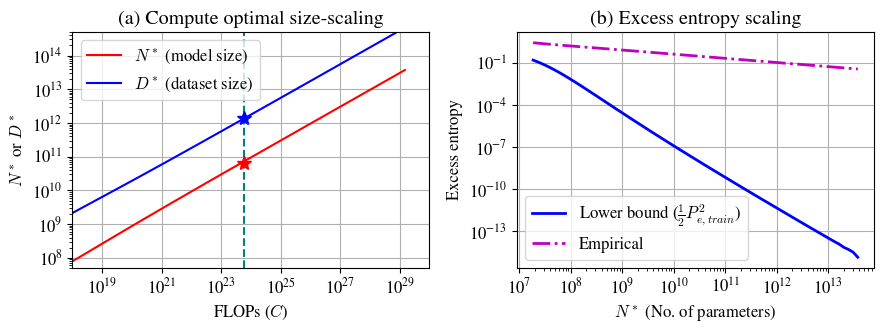

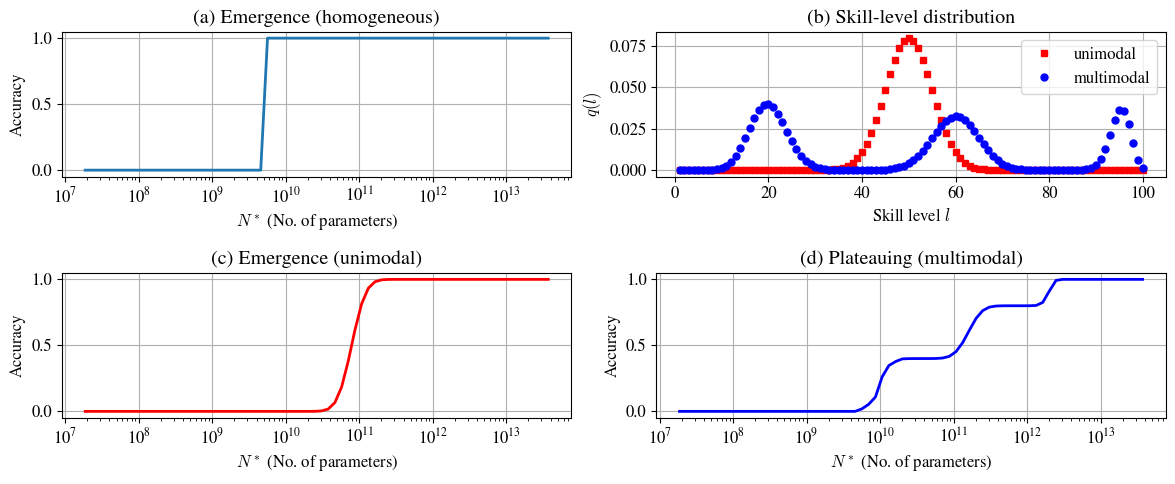

In [ ]:
import numpy as np
from matplotlib import cm
import matplotlib.pyplot as plt
from scipy.stats import *
import scipy as scp


FONT_SIZE = 12
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams["font.size"] = str(FONT_SIZE)
plt.rcParams['figure.figsize'] = 12, 5

dt, eps, eps_str = 6, 0.5, '0pt5'
degree_dist = 'binomial_binomial'
varsigma, tau = 1e7, 1e7

filename = degree_dist+'_biterr_dt'+str(dt)+'_eps'+eps_str+'_numpts200'
start_idx, end_idx, step_idx = 30, 170, 2

varsigma, tau = 2e5, 8e5
mult_fact = 6


flops_slearnt_dict = np.load(filename+'.npy', allow_pickle='TRUE').item()

flops_vec = np.array([float(x) for x in list(flops_slearnt_dict.keys())])[start_idx:end_idx:step_idx]
flops_vec_adjusted = flops_vec*varsigma*tau*mult_fact
PB_vec = (1-np.array([flops_slearnt_dict[str(flops_vec[x])]['s_learnt'] for x in range(len(flops_vec))])/np.array([flops_slearnt_dict[str(flops_vec[x])]['s_opt'] for x in range(len(flops_vec))]))
epsBP_vec = np.array([flops_slearnt_dict[str(flops_vec[x])]['eps_BP'] for x in range(len(flops_vec))])
s_opt_vec = np.array([flops_slearnt_dict[str(flops_vec[x])]['s_opt'] for x in range(len(flops_vec))])
s_learnt_opt_vec = np.array([flops_slearnt_dict[str(flops_vec[x])]['s_learnt'] for x in range(len(flops_vec))])
t_opt_vec = flops_vec/np.array([flops_slearnt_dict[str(flops_vec[x])]['s_opt'] for x in range(len(flops_vec))])
alpha_vec = np.array([flops_slearnt_dict[str(flops_vec[x])]['alpha'] for x in range(len(flops_vec))])

D_opt_vec = t_opt_vec*tau
N_opt_vec = s_opt_vec*varsigma

###################################################################
####################### Training loss scaling #####################
###################################################################

p_vec = dt/s_opt_vec
R_vec = s_opt_vec
del_vec = PB_vec


term_1a = 1
term_1b = (p_vec*(1-del_vec)+(1-p_vec))**R_vec
term_1c = del_vec*p_vec*R_vec*((p_vec*(1-del_vec)+(1-p_vec))**(R_vec-1))

term_2a = (1-p_vec)**R_vec + R_vec*p_vec*(1-p_vec)**(R_vec-1)
term_2b = (1-p_vec)**R_vec + R_vec*(1-del_vec)*p_vec*(1-p_vec)**(R_vec-1)
term_2c = del_vec*p_vec*R_vec*((1-p_vec)**(R_vec-1))

train_err = 1-((1-p_vec*del_vec)**(R_vec-1))*(1+p_vec*R_vec*del_vec)
train_err_approx = (dt*del_vec)**2

excess_entropy_lb = 0.5*(train_err**2)

A = 406.4
B = 410.7
alpha_scale = 0.34
beta_scale = 0.28
chinchilla_xs_entropy_scaling = A/(N_opt_vec**alpha_scale) + B/(D_opt_vec**beta_scale)

# Fit a linear regression line to the data
x_vec = np.log(N_opt_vec[20:50])
y_vec = np.log(excess_entropy_lb[20:50])
slope, intercept, r_value, p_value, std_err = linregress(x_vec, y_vec)
slope_str = str(f"{slope:0.2f}")

excess_entropy_lb_fit = np.exp(np.log(N_opt_vec)*slope+intercept)

###################################################################
####################### Emergence & Plateau #######################
###################################################################

from scipy.special import comb
import sympy as smp
import scipy.special as scpspl

## Emergence - unimodal
L = 100
L_vec = np.arange(1, L+1, 1)
Sl_vec = 1e3*np.ones(L)
min_nl, max_nl = 2, 8
q_nl_vec = np.ones(max_nl-min_nl)/(max_nl - min_nl)
nl_vec = np.arange(min_nl, max_nl+1, 1)
eta_l_vec = np.round(np.exp(7*L_vec/L))
sigma_l_vec = np.round(np.log2(L_vec))

y = np.array([binom.pmf(a, L, 0.5) for a in L_vec])
q_l_vec = y
q_l_vec_unimodal = q_l_vec.copy()

gcc_ratio_avg_unimodal, gcc_ratio_1subtask = get_accuracy_curve(q_l_vec, q_nl_vec, nl_vec, Sl_vec, s_opt_vec, t_opt_vec, sigma_l_vec, eta_l_vec, dt, gcc_ratio_func)

######### Plateau = Emergence + multimodal #########
pmf_wt_vec = np.array([0.4, 0.4, 0.2])
centroid_vec = np.array([0.2, 0.6, 0.95])

pmf_mix_vec = np.zeros(L)
for ind_mix in range(len(pmf_wt_vec)):
    this_pmf = np.array([binom.pmf(a, L, centroid_vec[ind_mix]) for a in L_vec])
    pmf_mix_vec = pmf_mix_vec+pmf_wt_vec[ind_mix]*this_pmf

q_l_vec = pmf_mix_vec
q_l_vec_multimodal = q_l_vec

gcc_ratio_avg_multi_modal, _ = get_accuracy_curve(q_l_vec, q_nl_vec, nl_vec, Sl_vec, s_opt_vec, t_opt_vec, sigma_l_vec, eta_l_vec, dt, gcc_ratio_func)


###################################################################
############################ PLOTS ################################
###################################################################
print("\n")
fig = plt.figure(0)
fig.set_size_inches(9, 3.5)

###################################################################
######################## R^*, T^* vs FLOPs ########################
###################################################################
plt.subplot(1,2,1)
plt.title("(a) Compute optimal size-scaling")

plt.axvline(x=5.73*1e23, color='#008080', linestyle='--')
plt.plot(flops_vec_adjusted, N_opt_vec, 'r-', label="$N^*$ (model size)")
plt.plot(flops_vec_adjusted, D_opt_vec, 'b-', label="$D^*$ (dataset size)")
plt.ylabel("$N^*$ or $D^*$")
plt.plot(5.73*1e23, 63*1e9, "r*", markersize=10)
plt.plot(5.73*1e23, 1.4*1e12, "b*", markersize=10)
plt.xlim((1e18, 1e30))
plt.ylim((5e7, 5e14))

plt.xlabel("FLOPs ($C$)")
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.grid()

###################################################################
############################ P_B vs R* ############################
###################################################################
plt.subplot(1,2,2)
plt.title("(b) Excess entropy scaling")
plt.plot(N_opt_vec, excess_entropy_lb, 'b-', label="Lower bound ($\\frac{1}{2} P_{e, train}^2$)", linewidth=2)
plt.plot(N_opt_vec, chinchilla_xs_entropy_scaling, 'm-.', label="Empirical", linewidth=2)
plt.xlabel("$N^*$ (No. of parameters)")
plt.ylabel("Excess entropy")
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.grid()
plt.tight_layout()

plt.savefig("chinchilla_loss_scaling.svg", format='svg')

print("\n")

###################################################################
###################################################################
###################################################################
plt.figure(1)

plt.subplot(2,2,1)
plt.title("(a) Emergence (homogeneous)")
plt.plot(N_opt_vec, gcc_ratio_1subtask, linewidth=2)
plt.xlabel("$N^*$ (No. of parameters)")
plt.ylabel("Accuracy")
plt.xscale("log")
plt.grid()

plt.subplot(2,2,2)
plt.title("(b) Skill-level distribution")
plt.plot(L_vec, q_l_vec_unimodal, "rs", markersize=5, label="unimodal")
plt.plot(L_vec, q_l_vec_multimodal, "bo", markersize=5, label="multimodal")
plt.xlabel("Skill level $l$")
plt.ylabel("$q(l)$")
plt.legend()
plt.grid()

###################################################################
############################ P_B vs R* ############################
###################################################################
plt.subplot(2,2,3)
plt.title("(c) Emergence (unimodal)")
plt.plot(N_opt_vec, gcc_ratio_avg_unimodal, "r-", linewidth=2)

plt.xlabel("$N^*$ (No. of parameters)")
plt.ylabel("Accuracy")
plt.xscale("log")
plt.grid()

###################################################################
############################ P_B vs R* ############################
###################################################################
plt.subplot(2,2,4)
plt.title("(d) Plateauing (multimodal)")
plt.plot(N_opt_vec, gcc_ratio_avg_multi_modal, "b-", linewidth=2)

plt.xlabel("$N^*$ (No. of parameters)")
plt.ylabel("Accuracy")
plt.xscale("log")
plt.grid()

###################################################################

plt.tight_layout()
# plt.savefig("emerg_plateau.svg", format='pdf')

plt.show(block=False)
